In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bayesmixpy import run_mcmc

In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
import scipy
from scipy.stats import invwishart
from scipy.stats import beta
from scipy.special import digamma
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib import cm

Data generation

1.0


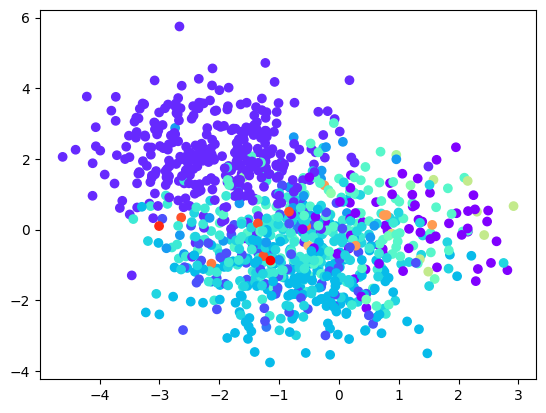

Final number of clusters:  20


In [6]:
seed=2023
np.random.seed(seed)

# Instantiate the first topic
alpha = 5
n = 1000
d = 2

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics =1
mu0 = np.zeros(d)
sigma2=1
Id=np.eye(d)
#sigma0 = np.identity(d)

#cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, sigma2*Id)

mus = [mu1]
#covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    #new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=sigma2*Id)
    mus.append(new_mu)
    #covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.sum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=Id)
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]

plt.scatter(xs, ys, color=cs)
plt.show()
print('Final number of clusters: ',len(mus))

MODEL IMPLEMENTATION
We start implementing the base case in which G0 is a normal with 0 mean and fixed covariance structure = sigma0*Identity and alpha is fixed =1.

## The Bayesian Model

\begin{align*}
    y_i \mid \theta_i=(\mu_i, \sigma^2_i) & \sim \mathcal{N}(\mu_i, \sigma^2_i) \\
    \theta_i \mid P & \sim P \\
    P & \sim DP(\alpha G_0) 
\end{align*}
And $G_0(d\mu, d\sigma^2) = \mathcal N(d\mu | \mu_0, \sigma^2/\lambda) \mathcal{IG}(\sigma^2 | a, b)$

We consider different prior specifications

### Fixed hyperparameters

$\alpha = 1$

$(\mu_0, \lambda, a, b) = (0, 0.1, 2, 2)$


In [ ]:
dp_params = """
fixed_value {
    totalmass: 1.0
}
"""

g0_params = """
fixed_values {
    mean: 0.0
    var_scaling: 1
    shape: 2.0
    scale: 0.1
}
"""

neal2_algo = """
algo_id: "Neal2"
rng_seed: 2023
iterations: 2000
burnin: 1000
init_num_clusters: 5
"""